In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision as tv
from torch import nn
from collections import defaultdict
from IPython.display import clear_output
import time

In [2]:
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
BATCH_SIZE = 128

train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:05<00:00, 109744590.43it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [3]:
by_merge_map = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9',
                10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I',
                19:'J', 20:'K', 21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R',
                28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z',
                36:'a', 37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q',
                45:'r', 46:'t'}

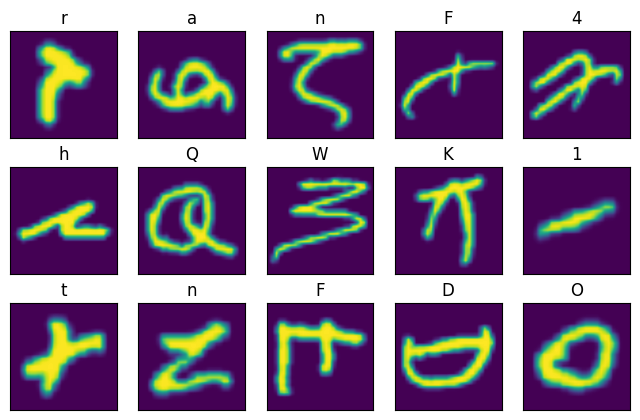

In [4]:
plt.figure(figsize=(8, 5))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_dataset[i][0][0])
    label_index = int(train_dataset[i][1])
    plt.title(by_merge_map[label_index])
plt.show()

In [5]:
classes = {}
for x,y in train_dataset:
    if y not in classes:
        classes[y] = 1
    else:
        classes[y] += 1

In [6]:
classes

{45: 2400,
 36: 2400,
 43: 2400,
 15: 2400,
 4: 2400,
 42: 2400,
 26: 2400,
 32: 2400,
 20: 2400,
 1: 2400,
 46: 2400,
 13: 2400,
 24: 2400,
 12: 2400,
 5: 2400,
 17: 2400,
 3: 2400,
 40: 2400,
 14: 2400,
 44: 2400,
 19: 2400,
 29: 2400,
 25: 2400,
 35: 2400,
 28: 2400,
 23: 2400,
 22: 2400,
 34: 2400,
 9: 2400,
 30: 2400,
 38: 2400,
 39: 2400,
 37: 2400,
 31: 2400,
 16: 2400,
 7: 2400,
 2: 2400,
 8: 2400,
 10: 2400,
 6: 2400,
 27: 2400,
 33: 2400,
 11: 2400,
 18: 2400,
 41: 2400,
 0: 2400,
 21: 2400}

In [7]:
len(classes)

47

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
def train(
    model, 
    criterion,
    optimizer, 
    train_iter,
    test_iter,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_iter:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_iter)
        train_acc /= len(train_iter) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in test_iter:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(test_iter)
        val_acc /= len(test_iter) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        

        
    return model, history

In [5]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Accuracy', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('Accuracy', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    plt.show()

In [9]:
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

In [10]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
for param in model.parameters():
    param.requires_grad = False

In [13]:
model.fc = nn.Linear(512, 47)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

resnet_model, resnet_history = train(
    model, criterion, optimizer, 
    train_iter, test_iter, 
    num_epochs=10
)

Epoch 10 of 10 took 313.801s
  training loss (in-iteration): 	0.821650
  validation loss (in-iteration): 	1.083804
  training accuracy: 			79.56 %
  validation accuracy: 			76.35 %


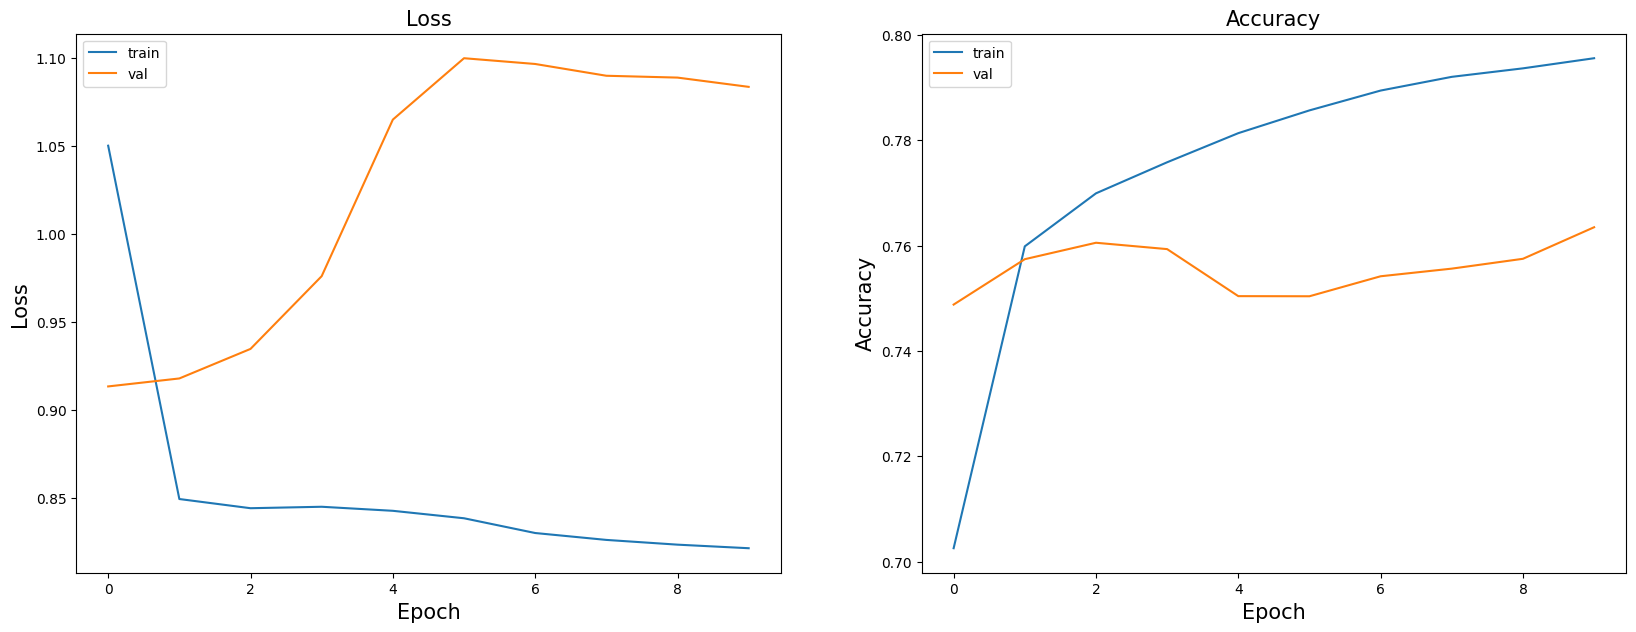

In [14]:
plot_learning_curves(resnet_history)

In [25]:
res = pd.DataFrame({'ResNet18_accuracy': resnet_history['acc']['val']})
res

,ResNet18_accuracy
0,0.748785
1,0.757403
2,0.760523
3,0.759316
4,0.750387
5,0.750364
6,0.754161
7,0.755611
8,0.757478
9,0.763469


In [19]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

In [20]:
model = vgg16(weights=VGG16_Weights.DEFAULT)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
for param in model.parameters():
    param.requires_grad = False

In [22]:
model.classifier[-1] = nn.Linear(4096, 47)

In [23]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

vgg_model, vgg_history = train(
    model, criterion, optimizer, 
    train_iter, test_iter, 
    num_epochs=10
)

Epoch 10 of 10 took 816.401s
  training loss (in-iteration): 	3.440347
  validation loss (in-iteration): 	1.549240
  training accuracy: 			58.47 %
  validation accuracy: 			72.80 %


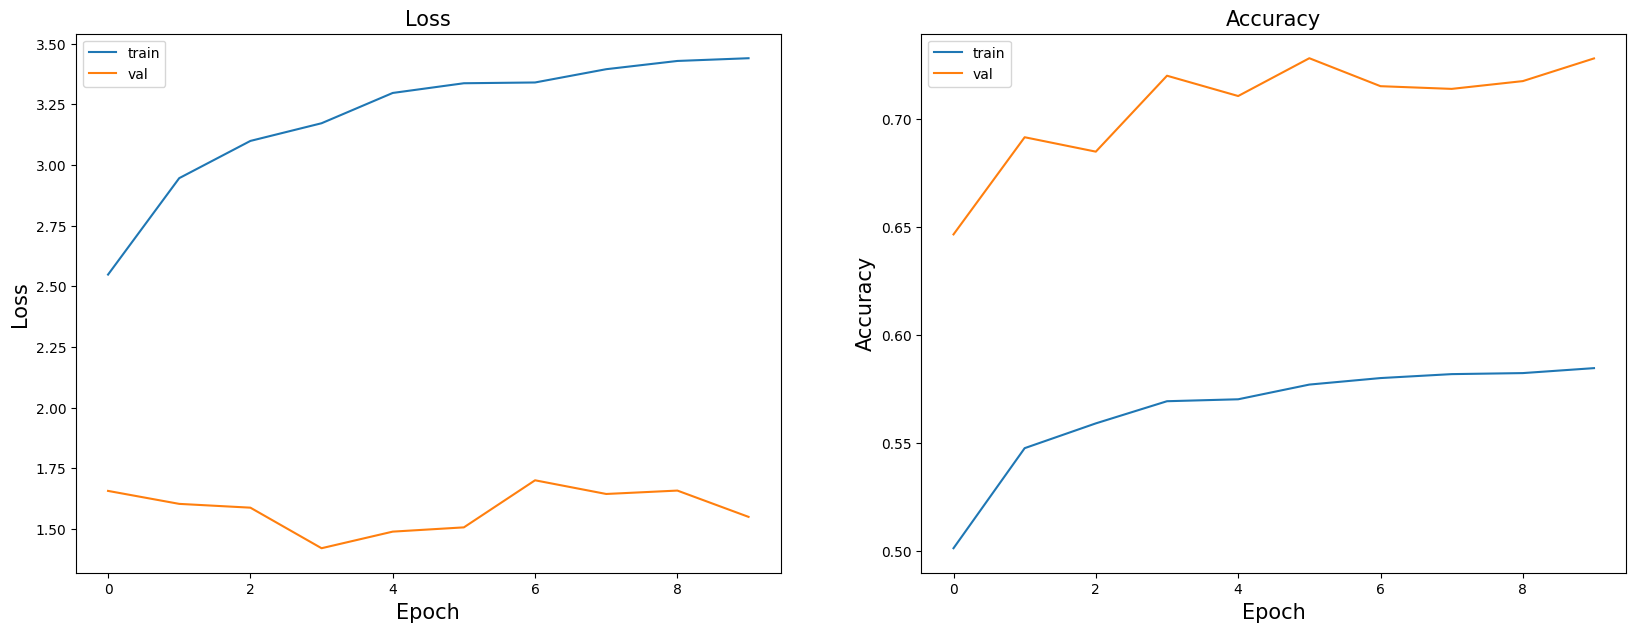

In [24]:
plot_learning_curves(vgg_history)

In [26]:
res['VGG16_accuracy'] = vgg_history['acc']['val']
res

,ResNet18_accuracy,VGG16_accuracy
0,0.748785,0.646577
1,0.757403,0.691532
2,0.760523,0.684865
3,0.759316,0.719988
4,0.750387,0.710596
5,0.750364,0.728081
6,0.754161,0.715144
7,0.755611,0.713899
8,0.757478,0.717497
9,0.763469,0.727990


In [30]:
from torchvision.models import inception_v3
from torchvision.models import Inception_V3_Weights

In [43]:
model = inception_v3(weights=Inception_V3_Weights.DEFAULT)
model.aux_logits=False
model

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [34]:
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])
BATCH_SIZE = 128

train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [39]:
model.fc = nn.Linear(2048, 47)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

inception_model, inception_history = train(
    model, criterion, optimizer, 
    train_iter, test_iter, 
    num_epochs=10
)

Epoch 10 of 10 took 860.862s
  training loss (in-iteration): 	2.992112
  validation loss (in-iteration): 	1.740191
  training accuracy: 			52.43 %
  validation accuracy: 			66.33 %


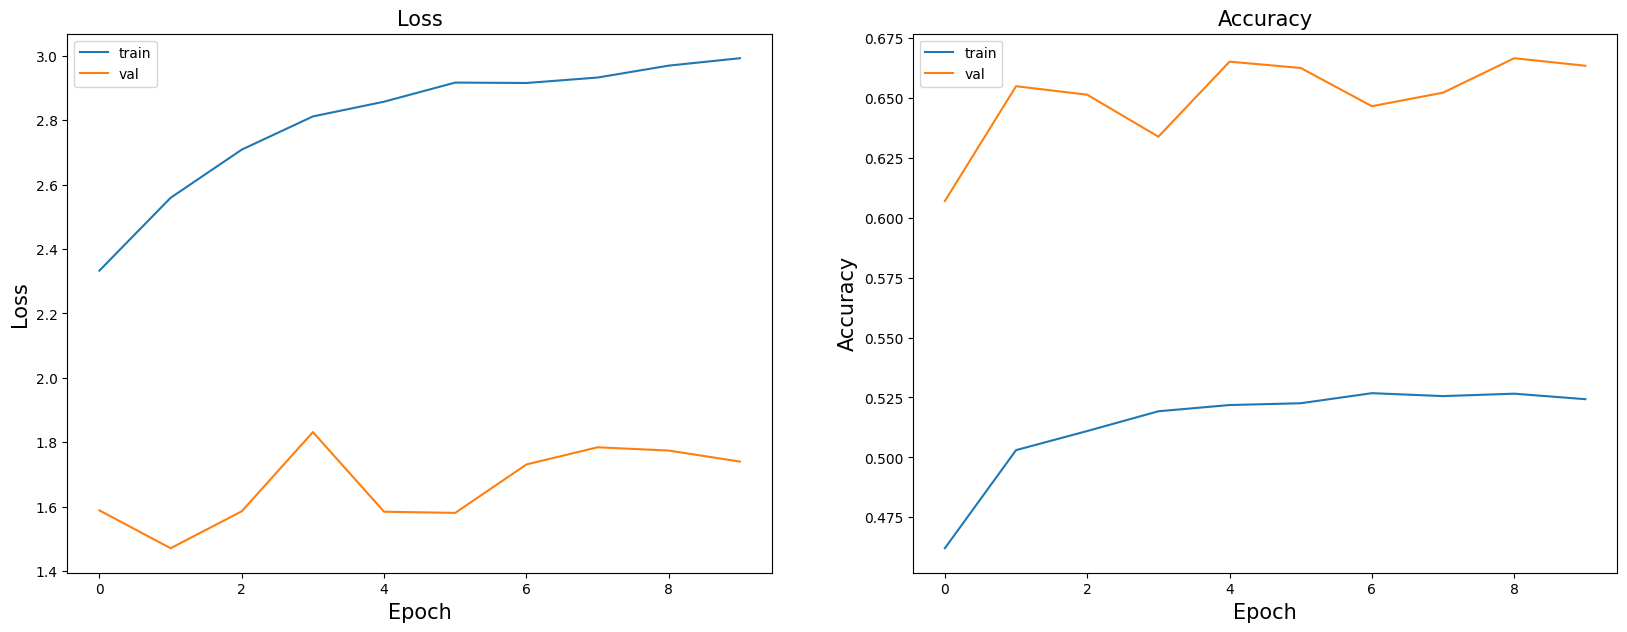

In [40]:
plot_learning_curves(inception_history)

In [41]:
res['inception_v3_accuracy'] = inception_history['acc']['val']
res

,ResNet18_accuracy,VGG16_accuracy,inception_v3_accuracy
0,0.748785,0.646577,0.606923
1,0.757403,0.691532,0.654823
2,0.760523,0.684865,0.651269
3,0.759316,0.719988,0.633762
4,0.750387,0.710596,0.665065
5,0.750364,0.728081,0.662423
6,0.754161,0.715144,0.646479
7,0.755611,0.713899,0.652127
8,0.757478,0.717497,0.666492
9,0.763469,0.727990,0.663349


In [53]:
res.to_csv('res.csv', index = False)

In [6]:
from torchvision.models import densenet161
from torchvision.models import DenseNet161_Weights

In [7]:
model = tv.models.densenet161(weights=DenseNet161_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 219MB/s]  


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [8]:
for param in model.parameters():
    param.requires_grad = False

In [9]:
model.classifier = nn.Linear(2208, 47)

In [10]:
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

densenet_model, densenet_history = train(
    model, criterion, optimizer, 
    train_iter, test_iter, 
    num_epochs=10
)

Epoch 10 of 10 took 1141.707s
  training loss (in-iteration): 	0.947940
  validation loss (in-iteration): 	1.658962
  training accuracy: 			80.08 %
  validation accuracy: 			74.62 %


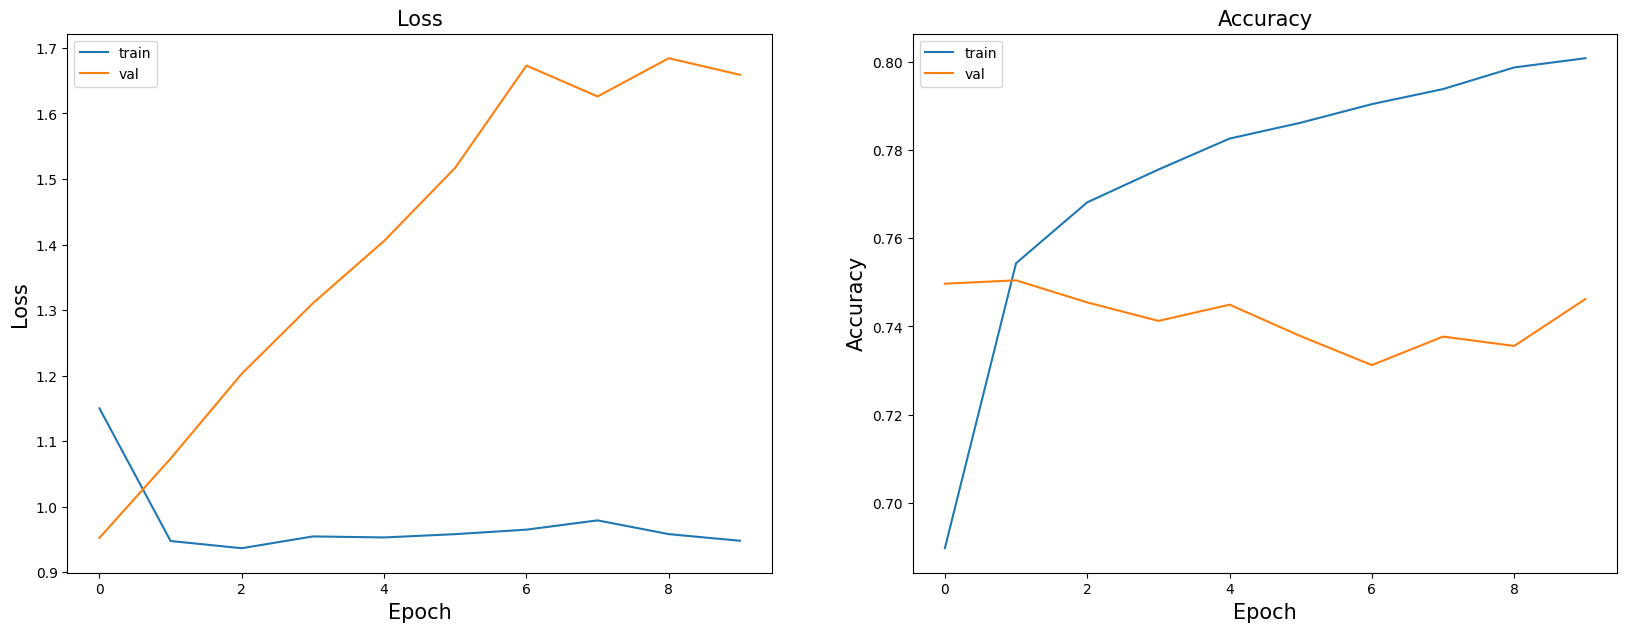

In [11]:
plot_learning_curves(densenet_history)

In [18]:
res['DenseNet161_accuracy'] = densenet_history['acc']['val']
res

,ResNet18_accuracy,VGG16_accuracy,inception_v3_accuracy,DenseNet161_accuracy
0,0.748785,0.646577,0.606923,0.749696
1,0.757403,0.691532,0.654823,0.750448
2,0.760523,0.684865,0.651269,0.745452
3,0.759316,0.719988,0.633762,0.741261
4,0.750387,0.710596,0.665065,0.744936
5,0.750364,0.728081,0.662423,0.737799
6,0.754161,0.715144,0.646479,0.731247
7,0.755611,0.713899,0.652127,0.737708
8,0.757478,0.717497,0.666492,0.735590
9,0.763469,0.727990,0.663349,0.746211


In [19]:
res.to_csv('summary.csv')

Обучить данные архитектуры с нуля не получилось, т.к обучение даже одной эпохи занимает не менее нескольких часов. Были взяты предобученные модели с замороженными весами и опробованы в качестве Feature extractor  